# Sparse Gaussian Process Regression

In this notebook we consider sparse Gaussian process regression (SGPR) <strong data-cite="titsias2009">Titsias (2009)</strong>. This is a solution for medium- to large-scale conjugate regression problems.
In order to arrive at a computationally tractable method, the approximate posterior is parameterized via a set of $m$ pseudo-points $\boldsymbol{z}$. Critically, the approach leads to $\mathcal{O}(nm^2)$ complexity for approximate maximum likelihood learning and $O(m^2)$ per test point for prediction.

In [1]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax as ox
from jax import jit
from jax.config import config
from jaxutils import Dataset
import jaxkern as jk

import gpjax as gpx

# Enable Float64 for more stable matrix inversions.
config.update("jax_enable_x64", True)
key = jr.PRNGKey(123)

## Dataset

With the necessary modules imported, we simulate a dataset $\mathcal{D} = (\boldsymbol{x}, \boldsymbol{y}) = \{(x_i, y_i)\}_{i=1}^{500}$ with inputs $\boldsymbol{x}$ sampled uniformly on $(-3., 3)$ and corresponding independent noisy outputs

$$\boldsymbol{y} \sim \mathcal{N} \left(\sin(7\boldsymbol{x}) + x \cos(2 \boldsymbol{x}), \textbf{I} * 0.5^2 \right).$$

We store our data $\mathcal{D}$ as a GPJax `Dataset` and create test inputs and labels for later.

In [2]:
n = 2500
noise = 0.5

x = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(n,)).sort().reshape(-1, 1)
f = lambda x: jnp.sin(2 * x) + x * jnp.cos(5 * x)
signal = f(x)
y = signal + jr.normal(key, shape=signal.shape) * noise

D = Dataset(X=x, y=y)

xtest = jnp.linspace(-3.1, 3.1, 500).reshape(-1, 1)
ytest = f(xtest)

To better understand what we have simulated, we plot both the underlying latent function and the observed data that is subject to Gaussian noise. We also plot an initial set of inducing points over the space.

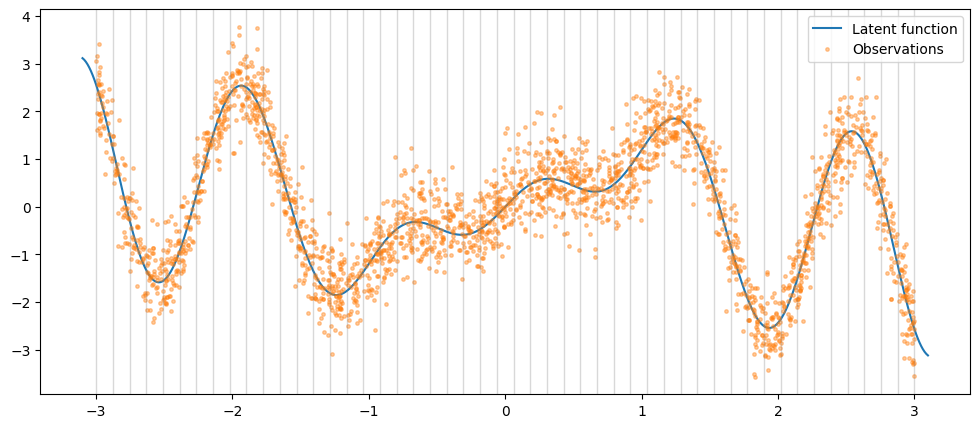

In [3]:
n_inducing = 50
z = jnp.linspace(-3.0, 3.0, n_inducing).reshape(-1, 1)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(xtest, ytest, label="Latent function", color="tab:blue")
ax.plot(x, y, "o", color="tab:orange", alpha=0.4, label="Observations", markersize=2.5)
[ax.axvline(x=z_i, color="tab:gray", alpha=0.3, linewidth=1) for z_i in z]
ax.legend(loc="best")
plt.show()

Next we define the posterior model for the data.

In [4]:
kernel = jk.RBF()
likelihood = gpx.Gaussian(num_datapoints=D.n)
prior = gpx.Prior(kernel=kernel)
p = prior * likelihood

We now define the SGPR model through `CollapsedVariationalGaussian`. Since the form of the collapsed optimal posterior depends on the Gaussian likelihood's observation noise, we pass this to the constructer.

In [5]:
q = gpx.CollapsedVariationalGaussian(
    prior=prior, likelihood=likelihood, inducing_inputs=z
)

We define our variational inference algorithm through `CollapsedVI`. This defines the collapsed variational free energy bound considered in <strong data-cite="titsias2009">Titsias (2009)</strong>.

In [6]:
sgpr = gpx.CollapsedVI(posterior=p, variational_family=q)

We now train our model akin to a Gaussian process regression model via the `fit` abstraction. Unlike the regression example given in the [conjugate regression notebook](https://gpjax.readthedocs.io/en/latest/nbs/regression.html), the inducing locations that induce our variational posterior distribution are now part of the model's parameters. Using a gradient-based optimiser, we can then _optimise_ their location such that the evidence lower bound is maximised.

In [7]:
parameter_state = gpx.initialise(sgpr, key)

negative_elbo = jit(sgpr.elbo(D, negative=True))

optimiser = ox.adam(learning_rate=5e-3)

inference_state = gpx.fit(
    objective=negative_elbo,
    parameter_state=parameter_state,
    optax_optim=optimiser,
    num_iters=2000,
)

learned_params, training_history = inference_state.unpack()

  0%|          | 0/2000 [00:00<?, ?it/s]

We show predictions of our model with the learned inducing points overlayed in grey.

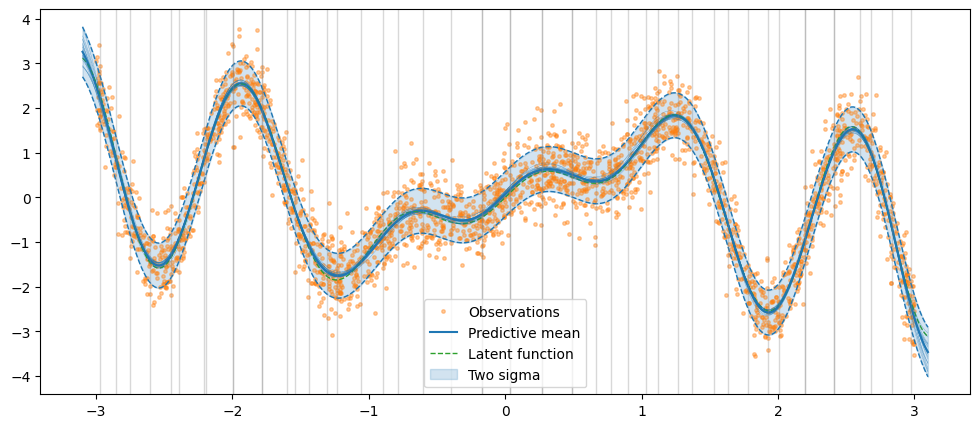

In [8]:
latent_dist = q(learned_params, D)(xtest)
predictive_dist = likelihood(learned_params, latent_dist)

samples = latent_dist.sample(seed=key, sample_shape=(20,))

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(x, y, "o", label="Observations", color="tab:orange", alpha=0.4, markersize=2.5)
ax.plot(xtest, predictive_mean, label="Predictive mean", color="tab:blue")

ax.fill_between(
    xtest.squeeze(),
    predictive_mean - predictive_std,
    predictive_mean + predictive_std,
    alpha=0.2,
    color="tab:blue",
    label="Two sigma",
)
ax.plot(
    xtest,
    predictive_mean - predictive_std,
    color="tab:blue",
    linestyle="--",
    linewidth=1,
)
ax.plot(
    xtest,
    predictive_mean + predictive_std,
    color="tab:blue",
    linestyle="--",
    linewidth=1,
)
ax.plot(
    xtest,
    ytest,
    label="Latent function",
    color="tab:green",
    linestyle="--",
    linewidth=1,
)


ax.plot(xtest, samples.T, color="tab:blue", alpha=0.8, linewidth=0.2)
[
    ax.axvline(x=z_i, color="tab:gray", alpha=0.3, linewidth=1)
    for z_i in learned_params["variational_family"]["inducing_inputs"]
]
ax.legend()
plt.show()

## Runtime comparison

Given the size of the data being considered here, inference in a GP with a full-rank covariance matrix is possible, albeit quite slow. We can therefore compare the speedup that we get from using the above sparse approximation with corresponding bound on the marginal log-likelihood against the marginal log-likelihood in the full model.

In [9]:
full_rank_model = gpx.Prior(kernel=gpx.RBF()) * gpx.Gaussian(num_datapoints=D.n)
fr_params, *_ = gpx.initialise(full_rank_model, key).unpack()
negative_mll = jit(full_rank_model.marginal_log_likelihood(D, negative=True))

%timeit negative_mll(fr_params).block_until_ready()

/var/folders/qb/c3b8rx055411rkfvdyzty9_80000gn/T/ipykernel_4124/2528392753.py:1: DeprecatedWarning: RBF is deprecated as of 0.5.5 and will be removed in 0.6.0. Use JaxKern for the RBF kernel
  full_rank_model = gpx.Prior(kernel=gpx.RBF()) * gpx.Gaussian(num_datapoints=D.n)


141 ms ± 11.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
params, *_ = gpx.initialise(sgpr, key).unpack()
negative_elbo = jit(sgpr.elbo(D, negative=True))

%timeit negative_elbo(params).block_until_ready()

3.5 ms ± 199 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


As we can see, the sparse approximation given here is around 50 times faster when compared against a full-rank model.

## System configuration

In [11]:
%reload_ext watermark
%watermark -n -u -v -iv -w -a 'Daniel Dodd'

Author: Daniel Dodd

Last updated: Sat Jan 14 2023

Python implementation: CPython
Python version       : 3.9.15
IPython version      : 8.8.0

gpjax     : 0.5.8
jax       : 0.4.1
jaxkern   : 0.0.4
optax     : 0.1.4
matplotlib: 3.3.3

Watermark: 2.3.1

